# Enriching Companies House data

![title](Images/ch_screenshot.png)

This notebook gives an overview on how business data from Companies House is imported, formatting and then enriched by exploiting various APIs and websites. Examples of applications include:
-  Retrieving official company websites using Google Places API
-  Scraping websites to get keywords to classify the industry of businesses.
-  Obtaining social media accounts and handles for companies and then use these to get a proxy for their web presence (number of followers, likes etc.)

## Importing data

The Free Company Data Product is a downloadable data snapshot containing basic company data of live companies on the Companies House register, and is the principal dataset for this project. This is updated monthly and needs to be downloaded before importing as a pandas dataframe. First, we need to import some modules...

### Modules

-  Pandas: provide easy-to-use data structures in Python
-  Numpy: provides fast and efficient multidimensional arrays, in addition to linear algebra and mathematical operations.
-  Matplotlib: provides plot to visualise data

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib.pyplot as plt
# Increase figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

### Loading and formatting Companies House dataset

The latest version of the Free Company Data Product can be downloaded here. http://download.companieshouse.gov.uk/en_output.html. The zip file that is downloaded is approximately 300MB, and the raw CSV file around 2GB. Once downloaded, ensure that the data is saved in the root folder of this notebook (or amend directory as required).

In [2]:
# to-do: investigate warning on mixed data types
ch_raw = pd.read_csv('/Users/dataexploitationmac1/Desktop/Faisal/Datasets/BasicCompanyDataAsOneFile-2018-02-01.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (41,42,43,44,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# preview the data
ch_raw.head(10) # first 10 rows 

,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
0,! LTD,08209948,NaN,NaN,METROHOUSE 57 PEPPER ROAD,HUNSLET,LEEDS,YORKSHIRE,NaN,LS10 2RU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/09/2019,11/09/2017
1,!BIG IMPACT GRAPHICS LIMITED,07382019,NaN,NaN,335 ROSDEN HOUSE,372 OLD STREET,LONDON,NaN,NaN,EC1V 9AV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05/10/2019,21/09/2016
2,!NNOV8 LIMITED,11006939,NaN,NaN,C/O FRANK HIRTH 1ST FLOOR,236 GRAY'S INN ROAD,LONDON,NaN,UNITED KINGDOM,WC1X 8HB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24/10/2019,NaN
3,!NSPIRED LTD,SC421617,NaN,NaN,26 POLMUIR ROAD,NaN,ABERDEEN,NaN,UNITED KINGDOM,AB11 7SY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/04/2020,11/04/2017
4,!NVERTD DESIGNS LIMITED,09152972,NaN,NaN,55A HIGH STREET,NaN,SILSOE,BEDFORDSHIRE,NaN,MK45 4EW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13/08/2020,30/07/2017
5,!OBAC LIMITED,FC031362,NaN,NaN,1ST AND 2ND FLOORS ELIZABETH HOUSE,LES RUETIES BRAYES,ST PETER PORT,GUERNSEY,GUERNSEY,GY1 1EW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,!OBAC UK LIMITED,07687209,NaN,NaN,ENDEAVOUR HOUSE,COOPERS END ROAD,STANSTED AIRPORT,NaN,NaN,CM24 1SJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13/07/2020,29/06/2017
7,!YOZO FASS LIMITED,02714021,NaN,NaN,1 VERONICA HOUSE,WICKHAM ROAD,BROCKLEY,NaN,NaN,SE4 1NQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26/05/2020,12/05/2017
8,""" BROOK VIEW ""MECHANICAL AND ELECTRICAL ENGINE...",10275228,NaN,NaN,62 STAKES ROAD,PURBROOK,WATERLOOVILLE,HAMPSHIRE,ENGLAND,PO7 5NT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/07/2020,11/07/2017
9,"""1 C O LIMITED""",03811958,NaN,NaN,FANE COURT,GREEN ROAD SHIPBOURNE,TONBRIDGE,KENT,NaN,TN11 9PL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05/08/2020,22/07/2017


In [4]:
# fields available
ch_raw.columns

Index(['CompanyName', ' CompanyNumber', 'RegAddress.CareOf',
       'RegAddress.POBox', 'RegAddress.AddressLine1',
       ' RegAddress.AddressLine2', 'RegAddress.PostTown', 'RegAddress.County',
       'RegAddress.Country', 'RegAddress.PostCode', 'CompanyCategory',
       'CompanyStatus', 'CountryOfOrigin', 'DissolutionDate',
       'IncorporationDate', 'Accounts.AccountRefDay',
       'Accounts.AccountRefMonth', 'Accounts.NextDueDate',
       'Accounts.LastMadeUpDate', 'Accounts.AccountCategory',
       'Returns.NextDueDate', 'Returns.LastMadeUpDate',
       'Mortgages.NumMortCharges', 'Mortgages.NumMortOutstanding',
       'Mortgages.NumMortPartSatisfied', 'Mortgages.NumMortSatisfied',
       'SICCode.SicText_1', 'SICCode.SicText_2', 'SICCode.SicText_3',
       'SICCode.SicText_4', 'LimitedPartnerships.NumGenPartners',
       'LimitedPartnerships.NumLimPartners', 'URI', 'PreviousName_1.CONDATE',
       ' PreviousName_1.CompanyName', ' PreviousName_2.CONDATE',
       ' PreviousName_2.C

In [ ]:
# remove unnecessary columns for this project
# why is copy() used? See explanation at link below:
# https://stackoverflow.com/questions/27673231/why-should-i-make-a-copy-of-a-data-frame-in-pandas
ch = ch_raw.iloc[:,[0,1,4,5,6,7,8,9,10,11,12,18,19,21,26,27,28,29]].copy()

# rename columns
ch.columns = ['name','crn','address1','address2','postTown','county','country', \
            'postcode','category','status','origin','accounts_lastMadeUpDate','accountCategory',\
            'returns_lastMadeUpDate','sic1','sic2','sic3','sic4']

In [ ]:
# format missing values
ch.sic1.replace('None Supplied', np.NaN, inplace=True)
ch = ch.dropna(subset=['name']) # delete rows with null business names (usually only a few values)

In [ ]:
# Produce a range of key stats 
# Key stats
print('---------')
print('Number of businesses: %s' %len(ch))
print('Missing SIC codes: %s' %ch.sic1.isnull().sum())
sic_comp = (1.0 - (float(ch.sic1.isnull().sum())/len(ch)))*100
print('SIC code completion: %.2f' %sic_comp + '%')
post_comp = (1.0 - (float(ch.postcode.isnull().sum())/len(ch)))*100
print('Postcode completion: %.2f' %post_comp + '%')
print('---------')
print('Category breakdown (top 5)')
print('')
print(ch.category.value_counts().head())
print('---------')
print('Account category (top 5)')
print('')
print(ch.accountCategory.value_counts().head())
print('---------')
print('Geographical breakdown (top 5)')
print('')
print(ch.origin.value_counts().head())
print('---------')
print('SIC code breakdown (top 5)')
print('')
print(ch.sic1.value_counts().head())

### Data exploration

Some pandas commands to explore the dataset, including setting up a function to find companies.

In [ ]:
ch.dtypes # types of each column - all objects

In [ ]:
def find_company(name):
    '''
    Searches companies house dataset for company name which include the given input which must be a string.
    '''
    name = name.lower()
    n = ch.name.str.lower().str.contains(name)
    x = input(str(n.sum()) + ' companies found. See list of companies? Y or N? ')
    if x.lower() == 'y':
        return ch[n]
    else:
        return True

In [ ]:
find_company('Burberry') # testing function on a few cases 

In [ ]:
find_company('Dyson')

Exploring SIC codes...

In [ ]:
ch.sic1.describe() # counts occurences and unique values

Sorting by the top 20 SIC codes shows that some of these are not very descriptive. Top of the list is 'Other business support service activities n.e.c'. Third is 'Dormant Company' and this is followed by 'Other service activities n.e.c'.

In [ ]:
ch.sic1.value_counts().head(20) # sort by top 20 sic codes

In [ ]:
ch.sic1.value_counts().head(30).plot() # shows skew of top categories
plt.show()

Checking if company reference numbers are unique

In [ ]:
ch.crn.describe() # all crns are unique

In [ ]:
ch.crn.isnull().sum() # 0

Exploring the address data

In [ ]:
ch.head() # reminder of the address fields

In [ ]:
ch.address1.describe() # 1.6 million unique addresses

In [ ]:
ch.address1.isnull().sum() # 27K null addresses

In [ ]:
ch.postTown.isnull().sum() # 93K missing town names

In [ ]:
ch.postcode.isnull().sum() # 52K missing post codes

### Export formatted dataset

In [ ]:
# Export dataset, named after MMYY of ch data
ch.to_csv('ch_2018-02.csv',index=False)

Optional: remove non-UK companies 

In [ ]:
ch_uk = ch[ch['origin'].isin(['United Kingdom','Great Britain','UNITED KINGDOM','GREAT BRITAIN','ENGLAND & WALES','UK'])]
ch_uk.reset_index(inplace=True)
ch_uk.to_csv('ch_2018-02.csv',index=False)

## Scraping data from Google Search Results

This section goes through the process of running google searches of business names in Companies House, scraping text from the results, and then returning a wordcloud of text from the first page of results.

The code below builds up the code for functions that run searches and produce
worldclouds as follows:

cloud(keyWords(search('Company Name')))

- search(string): returns a list of URLs from Google for the given term
- keyWords(list): screen-scrapes all visible text from the given list of URLs, and cleans
- cloud(string): after removing a given list of stopwords, produces a wordcloud

### Importing further modules and data

In [3]:
import webbrowser # to open web links
import nltk # natural language toolkit
from nltk.corpus import stopwords # Import the stop word list, may require download
# WordCloud modules
from wordcloud import WordCloud, STOPWORDS

import re # regular expressions 
from time import sleep # to pause web-scraper
import requests # allows you to send HTTP requests via Python
from bs4 import BeautifulSoup # beautiful soup for parsing of HTML

Read in formatted CH dataset if starting a new session. We'll refer to this at the end of the section after we've built up our tools to scrape and clean website text.

In [ ]:
ch = pd.read_csv('ch_2018-02.csv')

### Returning links for a Google Search term

First, we need to build some functionality to scrape the search results returned by Google.

In [4]:
# Set business search term as an example
biz = 'DYSON LIMITED'

In [8]:
# Read HTML
html = requests.get('https://www.google.co.uk/search?q='+ biz)
# Parse HTML into a BeautifulSoup object
soup = BeautifulSoup(html.content, 'html5lib')

In [9]:
# Get all links and put into list
list_of_links = []
for link in soup.find_all('a'):
    list_of_links.append(link.get('href'))

In [28]:
print(list_of_links) # needs cleaning up 

['https://www.google.co.uk/search?hl=en&tbm=isch&source=og&tab=wi', 'https://maps.google.co.uk/maps?hl=en&tab=wl', 'https://play.google.com/?hl=en&tab=w8', 'https://www.youtube.com/results?gl=GB&tab=w1', 'https://news.google.co.uk/nwshp?hl=en&tab=wn', 'https://mail.google.com/mail/?tab=wm', 'https://drive.google.com/?tab=wo', 'https://www.google.co.uk/intl/en/options/', 'http://www.google.co.uk/history/optout?hl=en', '/preferences?hl=en', 'https://accounts.google.com/ServiceLogin?hl=en&passive=true&continue=https://www.google.co.uk/search%3Fq%3DDYSON%2BLIMITED', '/webhp?hl=en-GB', '/search?q=DYSON+LIMITED&ie=UTF-8&prmd=ivnsp&source=lnms&tbm=isch&sa=X&ved=0ahUKEwjcrt3ci7XZAhUoKcAKHRIHBpUQ_AUIBQ', '/search?q=DYSON+LIMITED&ie=UTF-8&prmd=ivnsp&source=lnms&tbm=vid&sa=X&ved=0ahUKEwjcrt3ci7XZAhUoKcAKHRIHBpUQ_AUIBg', '/search?q=DYSON+LIMITED&ie=UTF-8&prmd=ivnsp&source=lnms&tbm=nws&sa=X&ved=0ahUKEwjcrt3ci7XZAhUoKcAKHRIHBpUQ_AUIBw', '/search?q=DYSON+LIMITED&ie=UTF-8&prmd=ivnsp&source=lnms&tbm=sh

In [29]:
# Cleaning up results
links = DataFrame({'urls':list_of_links}) #turn list into DF
links = links[links.urls.str.contains('/url?')] #Only search results

In [30]:
# remove cached sites
links = links[links.urls.str.contains('webcache.googleusercontent') == False]

In [31]:
# remove opening url?q= string
links = links.urls.str.replace('/url\?q=',"")
# after this, you don't need to call list anymore on the column

In [32]:
# remove suffixed &sa bit by splitting and drop index
links = links.str.split('&sa',1).reset_index().drop('index',1)
# this is now a dataframe

In [33]:
# use iterrows to grab first entry in each list which should be the working url
links_cleaned = []
for row in links.iterrows():
    links_cleaned.append(row[1][0][0])

In [34]:
# convert to dataframe
links_cleaned = DataFrame(links_cleaned)

We can now bring this together in one function. Note that we're screen-scraping from Google Search results so we'll need to be careful to not overload Google with search requests in quick succession (and potentially get our IP blocked).

In [36]:
def search_google(business_name):
    '''
    Takes in a business name and returns the links returned in the first page of Google Search results
    '''
    # Read HTML
    html = requests.get('https://www.google.co.uk/search?q='+business_name)
    # Parse HTML into a BeautifulSoup object
    soup = BeautifulSoup(html.content, 'html5lib')

    # Get all links and put into list
    list_of_links = []
    for link in soup.find_all('a'):
        list_of_links.append(link.get('href'))

    # Cleaning up results
    links = DataFrame({'urls':list_of_links}) #turn list into DF
    links = links[links.urls.str.contains('/url?')] #Only search results
    
    # remove cached sites
    links = links[links.urls.str.contains('webcache.googleusercontent') == False]

    # remove opening url?q= string
    links = links.urls.str.replace('/url\?q=',"")
    # after this, you don't need to call list anymore on the column

    # remove suffixed &sa bit by splitting and drop index
    links = links.str.split('&sa',1).reset_index().drop('index',1)
    # this is now a dataframe

    # use iterrows to grab first entry in each list which should be the working url
    links_cleaned = []
    for row in links.iterrows():
        links_cleaned.append(row[1][0][0])
        
    # convert to dataframe
    links_cleaned = DataFrame(links_cleaned)

    return links_cleaned[0]

In [38]:
burberry_links = search_google('burberry limited')

0                /settings/ads/preferences%3Fhl%3Den-GB
1                              https://uk.burberry.com/
2                          https://uk.burberry.com/men/
3                  https://uk.burberry.com/womens-bags/
4                     https://uk.burberry.com/children/
5           https://uk.burberry.com/mens-coats-jackets/
6             https://www.burberryplc.com/en/index.html
7     https://www.burberryplc.com/en/news-and-media/...
8     https://www.burberryplc.com/en/company/brand.html
9         https://www.burberryplc.com/en/investors.html
10          https://www.burberryplc.com/en/company.html
11    https://beta.companieshouse.gov.uk/company/001...
12    https://www.bloomberg.com/research/stocks/priv...
13                         https://burberrycareers.com/
14                  https://burberrycareers.com/search/
15            https://www.linkedin.com/company/burberry
16    https://uk.burberry.com/my-burberry-limited-ed...
17    https://uk.burberry.com/my-burberry-limite

In [ ]:
# use webbrowser library to open all links in browser (if needed)
for link in burberry_links:
    webbrowser.open(link)

### Extract key text from company websites 

Now that we've got the functionality to return links from Google search results, we want to navigate to each link, scrape and format the text to find words with explanatory value after removing stopwords and other standard website text. Let's use the Dyson website as an example. 

In [39]:
dyson_links = search_google('Dyson Limited')

In [41]:
# Inspecting the first search result
# Read HTML
html = requests.get(dyson_links[0])
# Parse HTML into a BeautifulSoup object
soup = BeautifulSoup(html.content, 'html5lib')

In [42]:
# Extracting text from key html sections
[s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]

[<head>
         
     <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
     
     
 	<meta content="Explore and shop our range of Vacuum cleaners, Hair care, Air treatment, Fans and Heaters, Lighting, Hand dryers." name="description"/>
 	<meta content="Explore and shop our range of Vacuum cleaners, Hair care, Air treatment, Fans and Heaters, Lighting, Hand dryers." property="og:description"/>
     
 	<meta content="/en.html" property="og:url"/>
 	<meta content="en_GB" property="og:locale"/>
 	
 	
     
     
 	<link href="/etc/designs/default/dyson-fav.ico" rel="icon" type="image/vnd.microsoft.icon"/>
 	<link href="/etc/designs/default/dyson-fav.ico" rel="shortcut icon" type="image/vnd.microsoft.icon"/>
     
     
     <link href="/en.html" rel="canonical"/>
 
     
     
 
     
 	<meta content="Dyson UK | Official Site" property="og:title"/>
 	
     
     <meta content="initial-scale=1, maximum-scale=1" name="viewport"/>
     <meta content="telephone=no" name="f

In [44]:
# Get all visible text
text = soup.getText().encode('ascii','ignore')

b"\n\t\n\n\n\n\n\n\n\n\n\n\n\t\n\t\t\n\t\t\t\t\n\t\t\t\t\t\n\t\t\t\t\t\t\n\t\t\t\t\t\t\t\n\t\t\t\t\t\n\t\t\t\n\n\t\t\n\t\t\t\n\t\t\t\t\n\t\t\t\t\n\t\t\t\n\t\n\n\n\n    \n    \n        \n\tSkip navigation\n\n\n\n\n   \n        \n        \n    \n    \n        \n            \n\n            \n    \n        \n            Cookie Settings\n            Dyson websites use cookies. By continuing to use our websites, you accept that cookies may be stored on your device, as outlined in our cookie policy.\n        \n        \n            \n                \n                   \n                \n            \n        \n    \n\n\n            \n\t\n\t\tThanks. We've saved your preferences.\n\t\tYou can update your contact preferences at any time in the Keep in touch section of Your Dyson.\n\t\tIf you have a Your Dyson account, you can log in below to manage your contact options. \n\t\t\n\t\t\t\n\t\t\t\tChange your contact preferences.\n\t\t\t\n\t\t\n\t\n\n\t\n\t\t\n\t\t\tChange your contact preferenc

We want to clean up this text by removing HTML tags and new line indicators. 

In [45]:
text_r = str(text).replace('\\n','').replace('\\t','').replace('\\r','')
print(text_r)

b"                Skip navigation                                                                                   Cookie Settings            Dyson websites use cookies. By continuing to use our websites, you accept that cookies may be stored on your device, as outlined in our cookie policy.                                                                                                                   Thanks. We've saved your preferences.You can update your contact preferences at any time in the Keep in touch section of Your Dyson.If you have a Your Dyson account, you can log in below to manage your contact options. Change your contact preferences.Change your contact preferences.                                                                                                                                                                                                                                                                                                                     

In [46]:
def stripsymbols(text):
    '''
    Use regular expressions to do a find-and-replace of HTML text.
    Function found online
    '''
    text = str(text)
    x = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text)
    x = re.sub('/(^|\b)@\S*($|\b)/'," ",x)
    x = re.sub('/(^|\b)#\S*($|\b)/'," ",x)
    x = re.sub("[^a-zA-Z]"," ",x)
    x = re.sub(r"(?:\@|https?\://)\S+", " ",x)
    return x

In [47]:
text_stripped = stripsymbols(text_r)
print(text_stripped)

b                 Skip navigation                                                                                   Cookie Settings            Dyson websites use cookies  By continuing to use our websites  you accept that cookies may be stored on your device  as outlined in our cookie policy                                                                                                                    Thanks  We ve saved your preferences You can update your contact preferences at any time in the Keep in touch section of Your Dyson If you have a Your Dyson account  you can log in below to manage your contact options  Change your contact preferences Change your contact preferences                                                                                                                                                                                                                                                                                                                      

Getting better! The final step is remove stop words by invoking the Natural Language Toolkit Library we imported earlier. Let's see what kind of stop words are classified in the library. 

In [48]:
print(stopwords.words('English'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

We can create a function to remove stopwords from website text.

In [49]:
def removeStopWords(text):
    '''
    Remove stopwords from given text string
    '''
    words = [w for w in text if not w in stopwords.words("english")]
    return words

In [50]:
# Prepare text for function by (a) changing to lowercase (2) remove whitespace from beginning and end 
# (3) splitting the text to create a list of individual wordsvisible_text_stripped.lower().strip().split() 
text_stripped_split = text_stripped.lower().strip().split()
text_stripped_split

['b',
 'skip',
 'navigation',
 'cookie',
 'settings',
 'dyson',
 'websites',
 'use',
 'cookies',
 'by',
 'continuing',
 'to',
 'use',
 'our',
 'websites',
 'you',
 'accept',
 'that',
 'cookies',
 'may',
 'be',
 'stored',
 'on',
 'your',
 'device',
 'as',
 'outlined',
 'in',
 'our',
 'cookie',
 'policy',
 'thanks',
 'we',
 've',
 'saved',
 'your',
 'preferences',
 'you',
 'can',
 'update',
 'your',
 'contact',
 'preferences',
 'at',
 'any',
 'time',
 'in',
 'the',
 'keep',
 'in',
 'touch',
 'section',
 'of',
 'your',
 'dyson',
 'if',
 'you',
 'have',
 'a',
 'your',
 'dyson',
 'account',
 'you',
 'can',
 'log',
 'in',
 'below',
 'to',
 'manage',
 'your',
 'contact',
 'options',
 'change',
 'your',
 'contact',
 'preferences',
 'change',
 'your',
 'contact',
 'preferences',
 'products',
 'cord',
 'free',
 'vacuums',
 'sticks',
 'handhelds',
 'latest',
 'offers',
 'corded',
 'vacuums',
 'uprights',
 'cylinders',
 'latest',
 'offers',
 'robot',
 'vacuums',
 'dyson',
 'eye',
 'robot',
 'hair'

Finally, running this through the removeStopWords function gives us something in a much better shape than the original text. 

In [51]:
text_cleaned = removeStopWords(text_stripped_split)
text_cleaned

['b',
 'skip',
 'navigation',
 'cookie',
 'settings',
 'dyson',
 'websites',
 'use',
 'cookies',
 'continuing',
 'use',
 'websites',
 'accept',
 'cookies',
 'may',
 'stored',
 'device',
 'outlined',
 'cookie',
 'policy',
 'thanks',
 'saved',
 'preferences',
 'update',
 'contact',
 'preferences',
 'time',
 'keep',
 'touch',
 'section',
 'dyson',
 'dyson',
 'account',
 'log',
 'manage',
 'contact',
 'options',
 'change',
 'contact',
 'preferences',
 'change',
 'contact',
 'preferences',
 'products',
 'cord',
 'free',
 'vacuums',
 'sticks',
 'handhelds',
 'latest',
 'offers',
 'corded',
 'vacuums',
 'uprights',
 'cylinders',
 'latest',
 'offers',
 'robot',
 'vacuums',
 'dyson',
 'eye',
 'robot',
 'hair',
 'care',
 'dyson',
 'supersonic',
 'hair',
 'dryer',
 'air',
 'treatment',
 'purifiers',
 'humidifiers',
 'fans',
 'heaters',
 'dyson',
 'cool',
 'fans',
 'dyson',
 'hot',
 'cool',
 'fan',
 'heaters',
 'lighting',
 'csys',
 'task',
 'lights',
 'cu',
 'beam',
 'suspended',
 'lights',
 'han

Wrapping this all up into a function...

In [52]:
def cleantext(text):
    text_r = str(text).replace('\\n','').replace('\\t','').replace('\\r','')
    text_stripped = stripsymbols(text_r)
    text_stripped_split = text_stripped.lower().strip().split()
    text_cleaned = removeStopWords(text_stripped_split)
    return ' '.join(text_cleaned) # returns a joined list of the remaining words 

In [53]:
dyson_cleaned = cleantext(text) # example of a function
dyson_cleaned

'b skip navigation cookie settings dyson websites use cookies continuing use websites accept cookies may stored device outlined cookie policy thanks saved preferences update contact preferences time keep touch section dyson dyson account log manage contact options change contact preferences change contact preferences products cord free vacuums sticks handhelds latest offers corded vacuums uprights cylinders latest offers robot vacuums dyson eye robot hair care dyson supersonic hair dryer air treatment purifiers humidifiers fans heaters dyson cool fans dyson hot cool fan heaters lighting csys task lights cu beam suspended lights hand dryers dyson airblade v hand dryer dyson airblade db hand dryer dyson airblade tap hand dryer business dyson business overview lighting business hand dryers business air treatment business hair care business resource library case studies sectors offices hotels education hospitality support get machine support guides troubleshooting tools replacement parts r

### Using the Natural Language Toolkit to tokenise and tag words

Another feature of the Natural Language Toolkit we can exploit is the ability to tag words and categorise them into their 'parts of speech' (i.e. nouns, verbs, adverbs). Perhaps this can be used to tag words from the scraped text, and retrieve nouns under the assumption that they provide the greatest explanatory power.

Let's test this with the scraped text from the previous section.

In [54]:
dyson_cleaned

'b skip navigation cookie settings dyson websites use cookies continuing use websites accept cookies may stored device outlined cookie policy thanks saved preferences update contact preferences time keep touch section dyson dyson account log manage contact options change contact preferences change contact preferences products cord free vacuums sticks handhelds latest offers corded vacuums uprights cylinders latest offers robot vacuums dyson eye robot hair care dyson supersonic hair dryer air treatment purifiers humidifiers fans heaters dyson cool fans dyson hot cool fan heaters lighting csys task lights cu beam suspended lights hand dryers dyson airblade v hand dryer dyson airblade db hand dryer dyson airblade tap hand dryer business dyson business overview lighting business hand dryers business air treatment business hair care business resource library case studies sectors offices hotels education hospitality support get machine support guides troubleshooting tools replacement parts r

In [55]:
tokens = nltk.word_tokenize(dyson_cleaned) # tokenize (split) the string
print(tokens)

['b', 'skip', 'navigation', 'cookie', 'settings', 'dyson', 'websites', 'use', 'cookies', 'continuing', 'use', 'websites', 'accept', 'cookies', 'may', 'stored', 'device', 'outlined', 'cookie', 'policy', 'thanks', 'saved', 'preferences', 'update', 'contact', 'preferences', 'time', 'keep', 'touch', 'section', 'dyson', 'dyson', 'account', 'log', 'manage', 'contact', 'options', 'change', 'contact', 'preferences', 'change', 'contact', 'preferences', 'products', 'cord', 'free', 'vacuums', 'sticks', 'handhelds', 'latest', 'offers', 'corded', 'vacuums', 'uprights', 'cylinders', 'latest', 'offers', 'robot', 'vacuums', 'dyson', 'eye', 'robot', 'hair', 'care', 'dyson', 'supersonic', 'hair', 'dryer', 'air', 'treatment', 'purifiers', 'humidifiers', 'fans', 'heaters', 'dyson', 'cool', 'fans', 'dyson', 'hot', 'cool', 'fan', 'heaters', 'lighting', 'csys', 'task', 'lights', 'cu', 'beam', 'suspended', 'lights', 'hand', 'dryers', 'dyson', 'airblade', 'v', 'hand', 'dryer', 'dyson', 'airblade', 'db', 'hand'

The tags bellow are given according to the Penn Treebank Project here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

The results are quite interesting. Words like 'vacuums', 'cylinders', 'robot' and 'dryers' are correctly given as nouns. However, some words are double-tagged. For instance, 'dyson' is given as a verb as well as a noun. 'Airblade' is given as a past-tense verb. 

From this example alone, filtering on nouns would yield the best results.

In [56]:
tagged = nltk.pos_tag(tokens) # categorise words according to their parts of speech
print(tagged)

[('b', 'NN'), ('skip', 'NN'), ('navigation', 'NN'), ('cookie', 'NN'), ('settings', 'NNS'), ('dyson', 'NN'), ('websites', 'NNS'), ('use', 'VBP'), ('cookies', 'NNS'), ('continuing', 'VBG'), ('use', 'NN'), ('websites', 'NNS'), ('accept', 'IN'), ('cookies', 'NNS'), ('may', 'MD'), ('stored', 'VB'), ('device', 'NN'), ('outlined', 'VBN'), ('cookie', 'NN'), ('policy', 'NN'), ('thanks', 'NNS'), ('saved', 'VBD'), ('preferences', 'NNS'), ('update', 'JJ'), ('contact', 'NN'), ('preferences', 'NNS'), ('time', 'NN'), ('keep', 'VB'), ('touch', 'JJ'), ('section', 'NN'), ('dyson', 'NN'), ('dyson', 'NN'), ('account', 'NN'), ('log', 'JJ'), ('manage', 'NN'), ('contact', 'NN'), ('options', 'NNS'), ('change', 'VBP'), ('contact', 'JJ'), ('preferences', 'NNS'), ('change', 'VBP'), ('contact', 'JJ'), ('preferences', 'NNS'), ('products', 'NNS'), ('cord', 'VBP'), ('free', 'JJ'), ('vacuums', 'NNS'), ('sticks', 'NNS'), ('handhelds', 'VBP'), ('latest', 'JJS'), ('offers', 'NNS'), ('corded', 'VBD'), ('vacuums', 'NNS'),

In [57]:
# Keep nouns only
tagged_nouns = " ".join([word[0] for word in tagged if word[1] in ['NNS','NN']])
tagged_nouns

'b skip navigation cookie settings dyson websites cookies use websites cookies device cookie policy thanks preferences contact preferences time section dyson dyson account manage contact options preferences preferences products vacuums sticks offers vacuums cylinders offers vacuums eye robot hair care dyson hair dryer air treatment purifiers humidifiers fans heaters fans fan heaters csys task lights beam lights hand dryers v hand dryer dyson hand dryer dyson hand dryer business dyson business overview business hand dryers business air treatment business hair care business resource case studies sectors offices hotels hospitality support machine support guides tools replacement parts information links number machine contact guarantee fixes co search dyson co search basket dyson sr basket items time shine shop mother day edition floor ceiling dyson technology shop divider line dyson institute engineering degrees generation james idea solves problem dyson demo experience dyson technology m

In [58]:
# Difference in list sizes - 1,352 removed words (out of 3,767)
len(dyson_cleaned) - len(tagged_nouns)

1352

### Master function and wordclouds

Let's collect everything we've built in Section 2 and build our final master functions.

In [59]:
def key_words(list_of_urls):
    '''
    From the given list of urls, this function scrapes, cleans (removing symbols and non-nouns)
    and gathers all text into a single string
    '''
    
    words_cleaned = '' # Set up empty string
    
    for website in list_of_urls:
        # try / except for troublesome websites
        try:
            html = requests.get(website)
            soup = BeautifulSoup(html.content, 'html5lib')
            [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
            visibleText = soup.getText().encode('ascii','ignore')
            words_cleaned += cleantext(visibleText) # Calling the function we built earlier 
        except:
            continue
            
    # Tokenize and tag words
    tokens = nltk.word_tokenize(words_cleaned)
    tagged = nltk.pos_tag(tokens)

    # Keep nouns only
    keywords = " ".join([word[0] for word in tagged if word[1] in ['NNS','NN']])
    return keywords

In [60]:
key_words(search_google('Dyson Limited')) # testing on an example - takes a few seconds to run

'b skip navigation cookie settings dyson websites cookies use websites cookies device cookie policy thanks preferences contact preferences time section dyson dyson account manage contact options preferences preferences products vacuums sticks offers vacuums cylinders offers vacuums eye robot hair care dyson hair dryer air treatment purifiers humidifiers fans heaters fans fan heaters csys task lights beam lights hand dryers v hand dryer dyson hand dryer dyson hand dryer business dyson business overview business hand dryers business air treatment business hair care business resource case studies sectors offices hotels hospitality support machine support guides tools replacement parts information links number machine contact guarantee fixes co search dyson co search basket dyson sr basket items time shine shop mother day edition floor ceiling dyson technology shop divider line dyson institute engineering degrees generation james idea solves problem dyson demo experience dyson technology m

This is best visualised in a word cloud...

In [61]:
def cloud(words):
    '''
    Function that takes in a string and produces a word cloud
    '''
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='black',
                          width=1800,
                          height=1400
                         ).generate(words)

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    return wordcloud

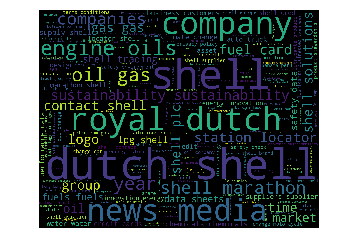

In [62]:
cloud(key_words(search_google('Royal Dutch Shell'))) # can take upto a minute to run

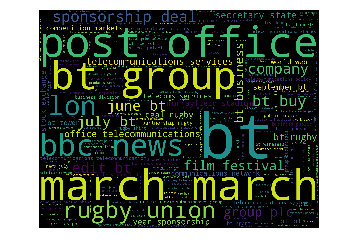

In [63]:
cloud(key_words(search_google('BT Group PLC')))

There is a lot of scope to improve this. Certain terms from websites that commonly re-occur can be filtered out by updating the stopwords set as follows.

In [ ]:
# ways to improve this: list of common names, weights and quantities, months and dates,

custom_words = ['sun','new','showbiz','tv','uk','john','lewis','partnership','offers','store',
'business','company','stores','shop','department','partner','street','london','partners','peter',
'jones','duration', 'views', 'minutes', 'month', 'version', 'system','tesco','september','privacy',
'policy','customer','service','home', 'company', 'london', 'price', 'offer', 'customer',
'service', 'home', 'year', 'london', 'day', 'march', 'business', 'shop','item','level','logo','menu',
'account','co','road','centre']


#STOPWORDS is a set, so need to use update method
STOPWORDS.update(custom_words)

## Connecting to Google Places API

We've relied on Google Search results to hopefully get websites that relate to a company term. However, the Google Places API can be linked to with a company's name and postcode and used to retrieve the company website and other details. 

Information from Google Places is displayed for certain businesses and places of interest as shown below.

![title](Images/google_places_screenshot.png)